In [9]:
import matplotlib.pyplot as plt
import sys
import numpy as np
import seaborn as sns
import pandas as pd
import jax
from model import ConfigurableModel
import pickle
np.set_printoptions(threshold=sys.maxsize)


def coeffsToComplex(coeffs):
    n = len(coeffs)
    complex_coeffs = np.zeros(n//2, dtype=complex)
    for i in range(n//2):
        complex_coeffs[i] = complex(coeffs[i], coeffs[2*i+1])
    return complex_coeffs


def buildPsiVals(kPsi, compl_ampls, x):
    val = np.zeros_like(x, dtype=float)  # Initialize val as a zero array with the same shape as x
    for ik in range(len(compl_ampls)):
        val += np.real(compl_ampls[ik] * np.exp(1j * kPsi[ik] * x))
    return val


def convert_to_complex(s):
    if s == "NaNNaNi":
        return 0
    else:
        return complex(s.replace('i', 'j'))
    
def split_complex_to_imaginary(complex_array):
    return np.concatenate([complex_array.real, complex_array.imag], axis=-1)


def loss_fn(params, model, inputs, true_coeffs, deterministic, rng_key):
    preds = model.apply({'params': params}, inputs, deterministic=deterministic, rngs={'dropout': rng_key})
    preds_real, preds_imag = preds[:, :6], preds[:, 6:]
    true_real, true_imag = true_coeffs[:, :6], true_coeffs[:, 6:]
    loss_real = jnp.mean((preds_real - true_real) ** 2)
    loss_imag = jnp.mean((preds_imag - true_imag) ** 2)
    return loss_real + loss_imag


x_range = np.arange(0, 350, 0.001)

kpsi_path = "/home/houtlaw/iono-net/data/baselines/high_everything/kPsi_20250120_163930.csv"
kpsi_df = pd.read_csv(kpsi_path)

coeffs_path ="/home/houtlaw/iono-net/data/baselines/high_everything/test_compl_ampls_20250120_163930.csv"
coeffs_df = pd.read_csv(coeffs_path).T

signal_path = "/home/houtlaw/iono-net/data/baselines/high_everything/test_uscStruct_vals_20250120_163930.csv"
signal_df = pd.read_csv(signal_path).T


for col in coeffs_df.columns:
    # Replace 'i' with 'j' for Python's complex number format and convert to complex numbers
    coeffs_df[col] = coeffs_df[col].str.replace('i', 'j').apply(complex)


In [10]:
kpsi_vals = kpsi_df.iloc[:, 0].values
display(kpsi_vals)

array([0.09424778, 0.18849556, 0.28274334, 0.37699112, 0.4712389 ,
       0.56548668])

In [11]:
coeffs_vals = coeffs_df.iloc[0,:].values
coeffs_vals

array([ 5.3697791 -2.7715654j ,  1.48359798-0.28494461j,
        0.52536837+0.41809587j, -0.03790014-0.37577201j,
        0.1961799 +0.14120626j,  0.15710111+0.0591206j ])

In [12]:
psiVals = buildPsiVals(coeffs_vals, kpsi_df.iloc[:,0].values, x_range)


/tmp/ipykernel_614803/1100832057.py:23: RuntimeWarning: overflow encountered in exp
  val += np.real(compl_ampls[ik] * np.exp(1j * kPsi[ik] * x))
/tmp/ipykernel_614803/1100832057.py:23: RuntimeWarning: invalid value encountered in multiply
  val += np.real(compl_ampls[ik] * np.exp(1j * kPsi[ik] * x))


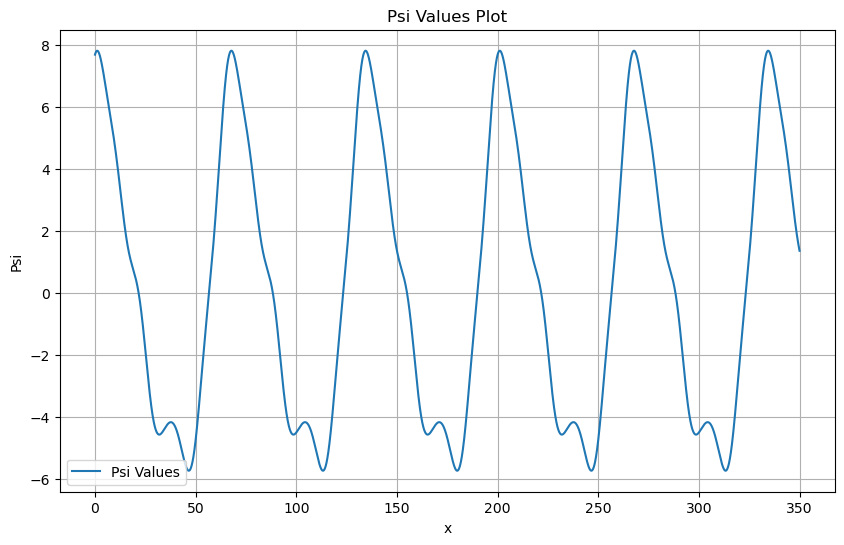

In [13]:
# Build Psi values for plotting
psiVals = buildPsiVals(kpsi_vals, coeffs_vals, x_range)

# Plot Psi values
plt.figure(figsize=(10, 6))
plt.plot(x_range, psiVals, label="Psi Values")
plt.xlabel("x")
plt.ylabel("Psi")
plt.title("Psi Values Plot")
plt.grid(True)
plt.legend()
plt.show()


## Get Model Output

In [14]:
data_df = pd.read_csv(signal_path, dtype = str)

data_df = data_df.dropna(axis = 1, how = 'any')

data_matrix = data_df.applymap(convert_to_complex).to_numpy().T

data_matrix_split = split_complex_to_imaginary(data_matrix)

print("Data Matrix Split Shape:", data_matrix_split.shape)


sample_signal = data_matrix_split[0,:]

Data Matrix Split Shape: (400, 2882)


/tmp/ipykernel_614803/1335260745.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_matrix = data_df.applymap(convert_to_complex).to_numpy().T


In [15]:
with open('/home/houtlaw/iono-net/data/baselines/high_everything/model_weights_20250121_174123.pkl', 'rb') as f:
    params = pickle.load(f)

# Define the model with the same architecture as used in training
architecture = [1093,328,963,188,514] 
activation_fn = jax.numpy.tanh  # Load from config if required
model = ConfigurableModel(architecture=architecture, activation_fn=activation_fn)


#data_matrix = data_df.applymap(convert_to_complex).to_numpy().T 
#kpsi_vals = kpsi_df.iloc[:, 0].values

sample_data = signal_df.iloc[0,:].values

# Run inference
def run_inference(model, params, input_data):
    output = model.apply({'params': params}, input_data, deterministic=True)
    return output

In [16]:
sample_output = run_inference(model, params, sample_signal)

2025-01-21 20:27:24.490142: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [17]:
print(sample_output)

[ 4.443229   -0.12278153 -0.11234449 -0.05909987 -0.07673605 -0.06307938
 -2.0530083  -1.0610543   0.49196506 -0.04258153  0.17658977  0.05890135]


In [18]:
sample_output_complex = sample_output[:len(sample_output)//2] + 1j*sample_output[len(sample_output)//2:]
print(sample_output_complex)

[ 4.443229  -2.0530083j  -0.12278153-1.0610543j  -0.11234449+0.49196506j
 -0.05909987-0.04258153j -0.07673605+0.17658977j -0.06307938+0.05890135j]


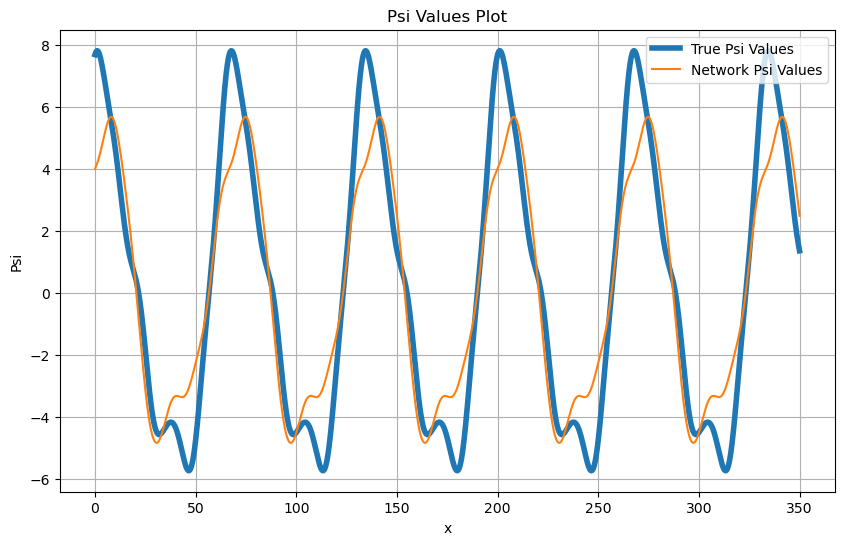

<Figure size 10000x10000 with 0 Axes>

In [19]:
# Build Psi values for plotting
model_psiVals = buildPsiVals(kpsi_vals, sample_output_complex, x_range)

# Plot Psi values
plt.figure(figsize=(10, 6))
plt.rcParams["figure.figsize"] = (100,100)
plt.plot(x_range, psiVals, label= "True Psi Values", lw=4)
plt.plot(x_range, model_psiVals, label="Network Psi Values")
plt.xlabel("x")
plt.ylabel("Psi")
plt.title("Psi Values Plot")
plt.grid(True)
plt.legend()
plt.show()
plt.savefig('psi_comparison.png', dpi=300)


# Evaluating Model Output

In [89]:
import numpy as np
from scipy.integrate import trapezoid


def evaluate_image(params):
    """
    Compute the image integral for all points using the given domain.

    Args:
        params (dict): A dictionary containing the following keys:
            - 'domain' (numpy.ndarray): The spatial domain for evaluation.
            - 'signal' (numpy.ndarray): Complex-valued signal with shape (2, N).
            - 'F' (float): Parameter related to the aperture or smoothing window.
            - 'dx' (float): Sampling interval for the domain.
            - 'window_type' (str): The type of window function to use. Options: 'rect', 'parab', 'parab_scaled'.
            - 'psi_type' (str): The type of psi function to use. Options: 'linear', 'fourier', 'random_fourier'.
            - 'psi_args' (dict): Additional arguments for the psi function.

    Returns:
        numpy.ndarray: A 2D array with the domain and computed image values.
    """
    # Extract parameters
    domain = params['domain']
    print("domain", domain.shape)
    signal = params['signal']
    print("signal", signal.shape)
    F = params['F']
    dx = params['dx']
    window_type = params['window_type']
    psi_type = params['psi_type']
    psi_args = params.get('psi_args', {})

    # Define window functions
    def rect_window(arr):
        return np.ones_like(arr)

    def parab_window(arr):
        arr_min, arr_max = np.min(arr), np.max(arr)
        return 1 - ((2 * (arr - arr_min)) / (arr_max - arr_min) - 1) ** 2

    def parab_scaled_window(arr):
        arr_min, arr_max = np.min(arr), np.max(arr)
        window = 1 - ((2 * (arr - arr_min)) / (arr_max - arr_min) - 1) ** 2
        return window / np.mean(window)

    # Map window types to functions
    window_functions = {
        'rect': rect_window,
        'parab': parab_window,
        'parab_scaled': parab_scaled_window,
    }
    window_func = window_functions[window_type]

    # Define psi functions
    def linear_psi(y, slope=1.0, intercept=0.0):
        return slope * y + intercept

    def fourier_psi(y, amps, wavenums):
        phases = np.outer(y, wavenums)
        return np.real(np.sum(np.exp(1j * phases) * amps, axis=1))

    def random_fourier_psi(y, amps, wavenums, seed=55):
        np.random.seed(seed)
        random_phases = np.random.uniform(0, 2 * np.pi, len(wavenums))
        phases = np.outer(y, wavenums) + random_phases
        return np.real(np.sum(np.exp(1j * phases) * amps, axis=1))

    # Map psi types to functions
    psi_functions = {
        'linear': linear_psi,
        'fourier': fourier_psi,
        'random_fourier': random_fourier_psi,
    }
    psi_func = psi_functions[psi_type]

    # Calculate the image
    imag_val = np.empty_like(signal[1, :], dtype='complex128')
    imag_val[:] = np.nan

    for yidx, y in enumerate(domain):
        x0 = max(signal[0, 0], y - F / 2)
        x1 = min(signal[0, -1], y + F / 2)
        mask = (signal[0, :] >= x0) & (signal[0, :] <= x1)

        base = signal[0, mask]
        #print("base",base)
        signal_vals = signal[1, mask]
        #print("signal_vals", signal_vals)
        waveform = np.exp(-1j * np.pi * (base - y) ** 2 / F)
        #print("waveform", waveform)
        psi_vals = np.exp(1j * psi_func(y, **psi_args))
        #print("psi_vals",psi_vals)
        window = window_func(base)

        #print(waveform, signal_vals, window, psi_vals)
       # print('--')

        heights = waveform * signal_vals * window * psi_vals
        #print("heights", heights)
       #print(np.absolute(trapezoid(heights, base, dx) / F))
        imag_val[yidx] = np.absolute(trapezoid(heights, base, dx) / F)
    return np.vstack((domain, imag_val))


In [90]:
x_range = pd.read_csv('/home/houtlaw/iono-net/data/SAR_AF_ML_toyDataset_etc/radar_coeffs_csv_small/meta_X_20241117_203151.csv').iloc[:,0].values
x_range.shape

(1441,)

In [91]:
signal_df_clean = signal_df.map(convert_to_complex);

sample_signal = signal_df_clean.iloc[10,:].values
x_range.shape


sample_signal_vals = np.vstack((x_range, sample_signal))

sample_signal_vals.shape


(2, 1441)

In [92]:
import json

with open('/home/houtlaw/iono-net/data/SAR_AF_ML_toyDataset_etc/radar_coeffs_csv_small/setup_20241117_203151.json') as f:
    setup = json.load(f)

print(setup)

{'F': 100, 'ionoNharm': 6, 'domainLengthInF': 3.6, 'maxN_PS': 15, 'PoissonLambda_amplPS': 5, 'numPsiSamples': 7, 'xi': 0.5, 'relNoiseCoeff': 0.4, 'addSpeckleCoeff': 0.4, 'ionoAmplOverPi': 2, 'F_to_lmax': 1.5, 'windowType': 'rect', 'sumType': 'trapz'}


In [93]:
params_true = {'domain': x_range, 'signal': sample_signal_vals, 'F': 100, 'dx': 0.25, 'window_type': 'rect', 'psi_type': 'fourier', 'psi_args': {'amps': coeffs_vals, 'wavenums': kpsi_vals}}

true_image = evaluate_image(params_true)

domain (1441,)
signal (2, 1441)


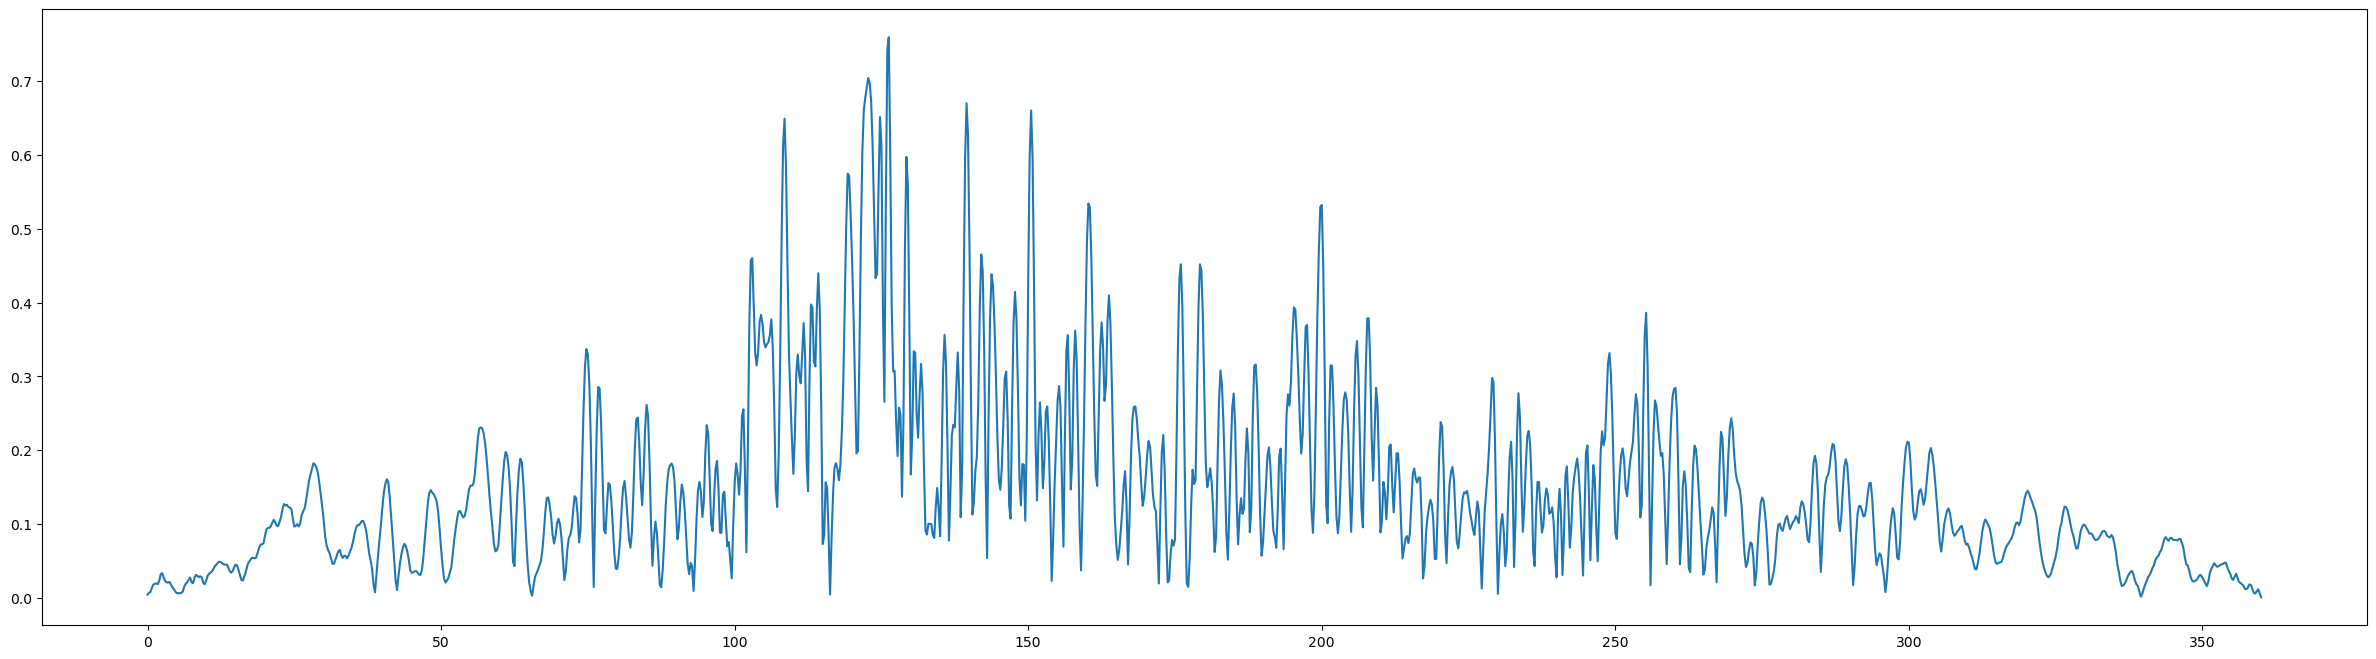

In [94]:
fig = plt.figure(figsize=(30, 8))
plt.plot(np.absolute(true_image[0]), np.absolute(true_image[1]))

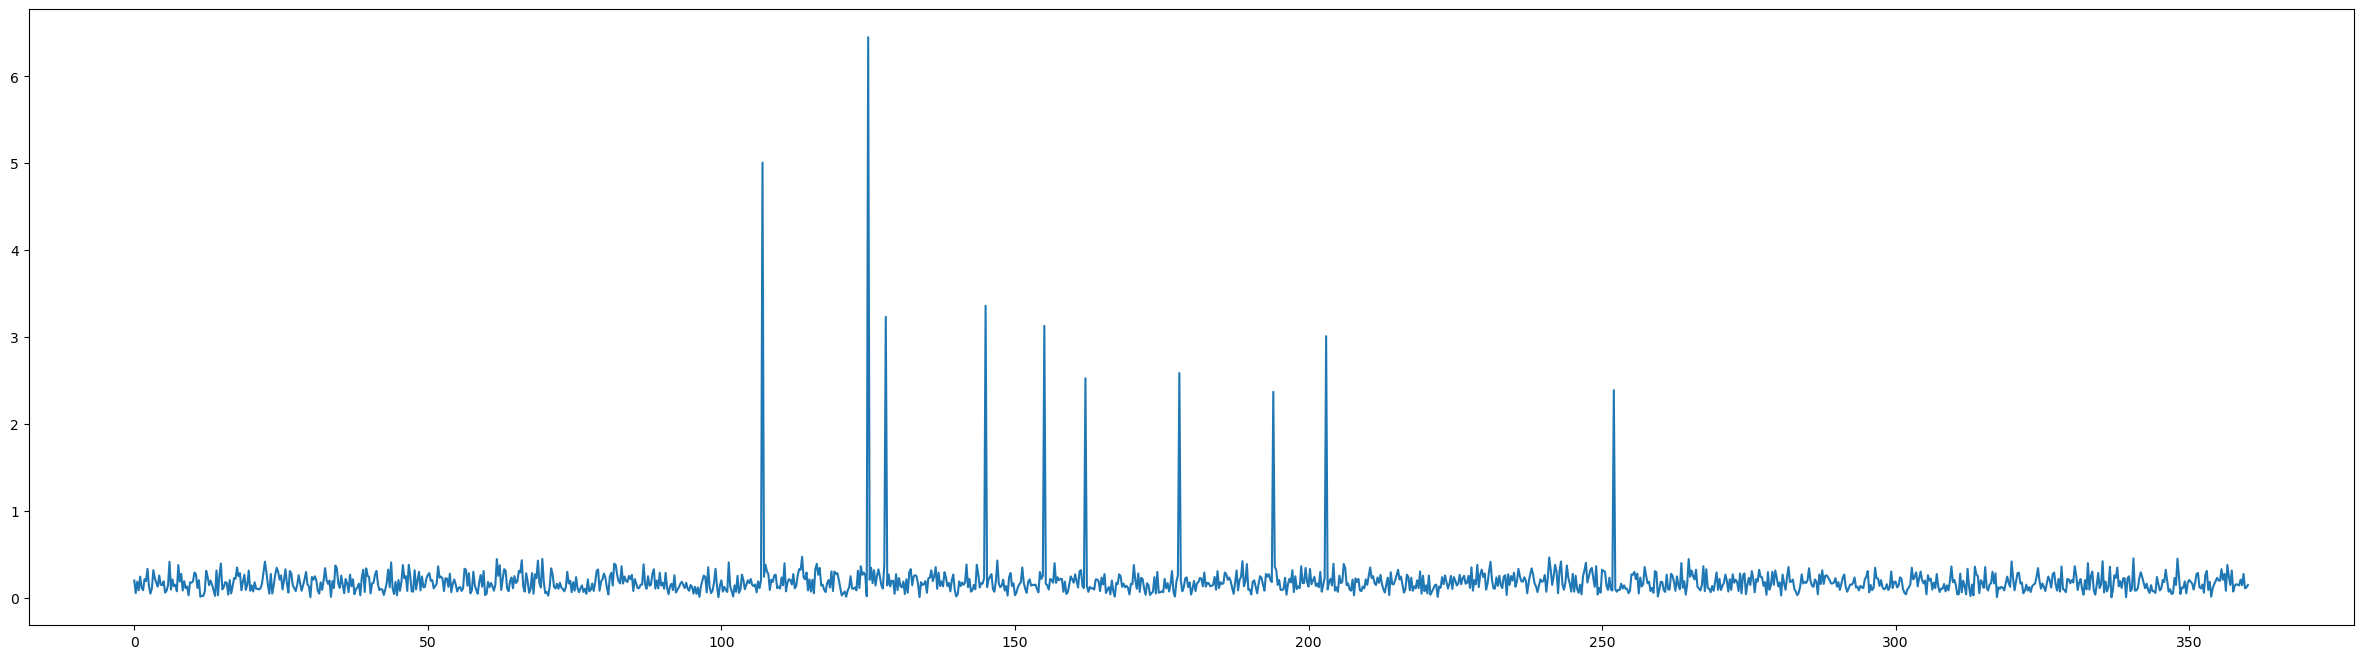

In [95]:
true_image_10 = pd.read_csv('/home/houtlaw/iono-net/data/SAR_AF_ML_toyDataset_etc/radar_coeffs_csv_small/nuStruct_withSpeckle_20241117_203151.csv').iloc[:,10]
x_range = pd.read_csv('/home/houtlaw/iono-net/data/SAR_AF_ML_toyDataset_etc/radar_coeffs_csv_small/meta_X_20241117_203151.csv').iloc[:,0].values
true_image_clean_10 = true_image_10.map(convert_to_complex).map(np.absolute)


fig = plt.figure(figsize=(30, 8))
plt.plot(x_range, true_image_clean_10)
